In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col, mean
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Initialize SparkSession
spark = SparkSession.builder.appName("HealthComplaintsRegression").getOrCreate()

In [4]:
# Load Dataset
df = spark.read.csv("keluhan_kesehatan_masyarakat.csv", header=True, inferSchema=True)

In [5]:
# Replace spaces with underscores in column names
df = df.toDF(*(col.replace(" ", "_") for col in df.columns))

In [6]:
# Convert "presentase" column to a numerical type
df = df.withColumn("presentase", df["presentase"].cast("double"))

In [7]:
# Fill NaN values with the mean of the "presentase" column
mean_value = df.agg(mean("presentase")).collect()[0][0]
df = df.fillna(mean_value, subset=["presentase"])

In [8]:
# Prepare Features and Target
assembler = VectorAssembler(inputCols=["tahun", "presentase"], outputCol="features")
df = assembler.transform(df)

In [11]:
# Create Separate Models for Each Gender
genders = [row.jenis_kelamin for row in df.select("jenis_kelamin").distinct().collect()]

plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

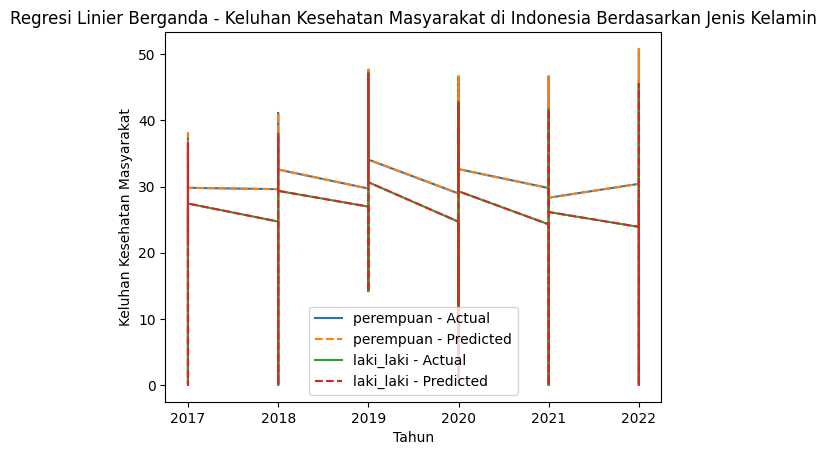

In [12]:
for gender in genders:
    # Filter data for each gender
    gender_df = df.filter(col("jenis_kelamin") == gender)

    # Create Linear Regression Model
    lr = LinearRegression(featuresCol="features", labelCol="presentase")
    model = lr.fit(gender_df)

    # Visualize Results
    pd_df = gender_df.select("tahun", "presentase").toPandas()

    plt.plot(pd_df["tahun"], pd_df["presentase"], label=f"{gender} - Actual")
    plt.plot(pd_df["tahun"], model.transform(gender_df).select("prediction").toPandas(), linestyle='dashed', label=f"{gender} - Predicted")

plt.xlabel("Tahun")
plt.ylabel("Keluhan Kesehatan Masyarakat")
plt.title("Regresi Linier Berganda - Keluhan Kesehatan Masyarakat di Indonesia Berdasarkan Jenis Kelamin")
plt.legend()
plt.show()

In [13]:
# Group by province and calculate the average presentase over the years
province_avg_presentase = df.groupBy("nama_wilayah").avg("presentase")

In [14]:
# Get the top 10 provinces with the highest average presentase
top_10_provinces = province_avg_presentase.orderBy(col("avg(presentase)").desc()).limit(10)

In [15]:
# Extract province names
province_names = [row.nama_wilayah for row in top_10_provinces.collect()]

In [16]:
# Create separate DataFrames for each province
province_dfs = [df.filter(col("nama_wilayah") == province) for province in province_names]

In [17]:
# Plot line charts for each province
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

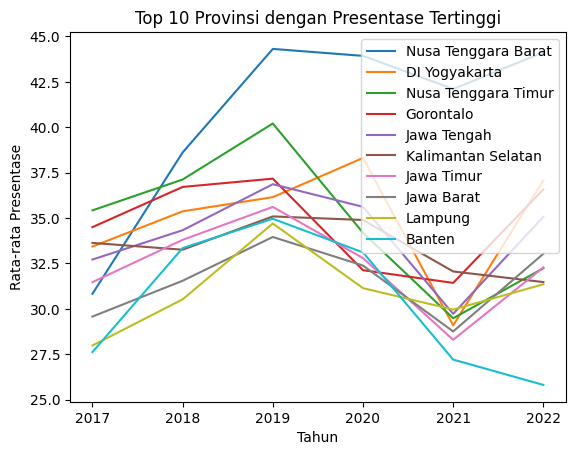

In [18]:
for i, province_df in enumerate(province_dfs):
    plt.plot(
        province_df.select("tahun").distinct().orderBy("tahun").toPandas()["tahun"],
        province_df.groupBy("tahun").avg("presentase").orderBy("tahun").toPandas()["avg(presentase)"],
        label=province_names[i]
    )

plt.xlabel("Tahun")
plt.ylabel("Rata-rata Presentase")
plt.title("Top 10 Provinsi dengan Presentase Tertinggi")
plt.legend()
plt.show()

In [21]:
# Get the top 10 provinces with the lowest average presentase
bottom_10_provinces = province_avg_presentase.orderBy(col("avg(presentase)").asc()).limit(10)

In [22]:
# Extract province names
province_names = [row.nama_wilayah for row in bottom_10_provinces.collect()]

In [23]:
# Create separate DataFrames for each province
province_dfs = [df.filter(col("nama_wilayah") == province) for province in province_names]

In [24]:
# Plot line charts for each province
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

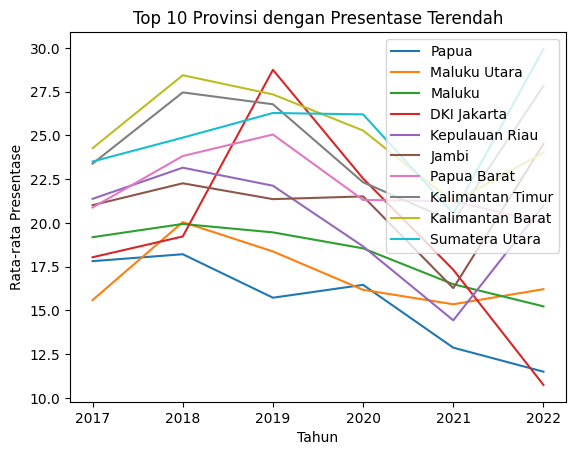

In [25]:
for i, province_df in enumerate(province_dfs):
    plt.plot(
        province_df.select("tahun").distinct().orderBy("tahun").toPandas()["tahun"],
        province_df.groupBy("tahun").avg("presentase").orderBy("tahun").toPandas()["avg(presentase)"],
        label=province_names[i]
    )

plt.xlabel("Tahun")
plt.ylabel("Rata-rata Presentase")
plt.title("Top 10 Provinsi dengan Presentase Terendah")
plt.legend()
plt.show()

In [27]:
# Visualization
pd_df = df.select("tahun", "presentase").toPandas()  # Corrected target column

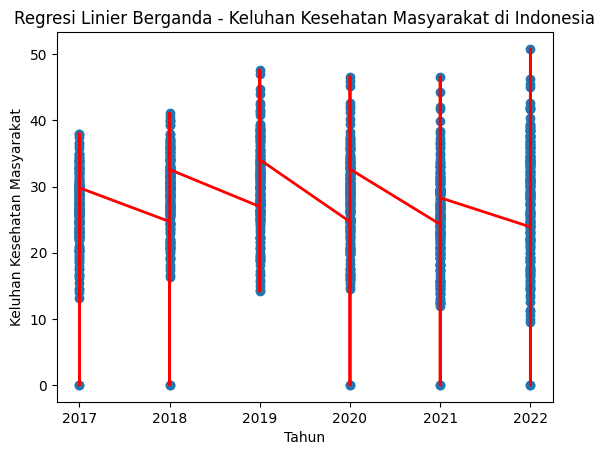

In [28]:
plt.scatter(pd_df["tahun"], pd_df["presentase"])
plt.plot(pd_df["tahun"], model.transform(df).select("prediction").toPandas(), color="red", linewidth=2)
plt.xlabel("Tahun")
plt.ylabel("Keluhan Kesehatan Masyarakat")
plt.title("Regresi Linier Berganda - Keluhan Kesehatan Masyarakat di Indonesia")
plt.show()

In [29]:
# Filter data for males in all provinces
male_df = df.filter((col("jenis_kelamin") == "laki_laki"))

In [30]:
# Group by province and calculate the average presentase over the years
province_avg_presentase = male_df.groupBy("nama_wilayah").avg("presentase")

In [31]:
# Get the provinces with the lowest average presentase
bottom_provinces = province_avg_presentase.orderBy(col("avg(presentase)").asc()).limit(10)

In [32]:
# Extract province names
province_names = [row.nama_wilayah for row in bottom_provinces.collect()]

In [33]:
# Create separate DataFrames for each province
province_dfs = [male_df.filter(col("nama_wilayah") == province) for province in province_names]

In [34]:
# Plot line charts for each province
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

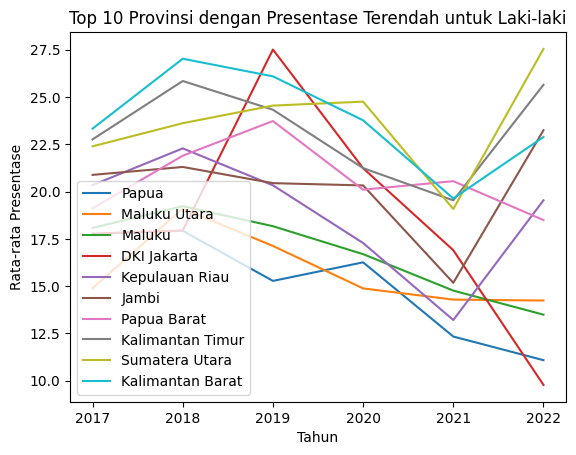

In [35]:
for i, province_df in enumerate(province_dfs):
    plt.plot(
        province_df.select("tahun").distinct().orderBy("tahun").toPandas()["tahun"],
        province_df.groupBy("tahun").avg("presentase").orderBy("tahun").toPandas()["avg(presentase)"],
        label=province_names[i]
    )

plt.xlabel("Tahun")
plt.ylabel("Rata-rata Presentase")
plt.title("Top 10 Provinsi dengan Presentase Terendah untuk Laki-laki")
plt.legend()
plt.show()

In [36]:
# Get the provinces with the highest average presentase
top_provinces = province_avg_presentase.orderBy(col("avg(presentase)").desc()).limit(10)

In [37]:
# Extract province names
province_names = [row.nama_wilayah for row in top_provinces.collect()]

In [38]:
# Create separate DataFrames for each province
province_dfs = [male_df.filter(col("nama_wilayah") == province) for province in province_names]

In [39]:
# Plot line charts for each province
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

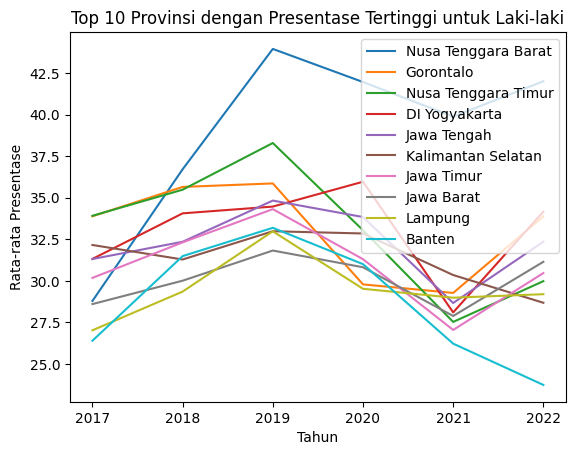

In [40]:
for i, province_df in enumerate(province_dfs):
    plt.plot(
        province_df.select("tahun").distinct().orderBy("tahun").toPandas()["tahun"],
        province_df.groupBy("tahun").avg("presentase").orderBy("tahun").toPandas()["avg(presentase)"],
        label=province_names[i]
    )

plt.xlabel("Tahun")
plt.ylabel("Rata-rata Presentase")
plt.title("Top 10 Provinsi dengan Presentase Tertinggi untuk Laki-laki")
plt.legend()
plt.show()

In [42]:
# Group by province and calculate the average presentase over the years
province_avg_presentase = male_df.groupBy("nama_wilayah").avg("presentase")

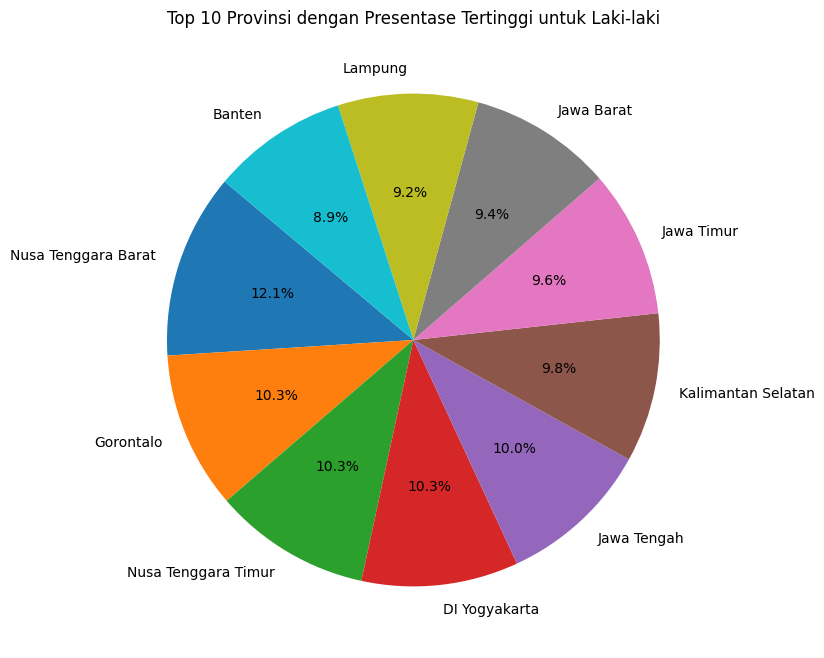

In [43]:
# Get the provinces with the highest average presentase
top_provinces = province_avg_presentase.orderBy(col("avg(presentase)").desc()).limit(10)

# Extract province names and their corresponding average presentase
province_names = [row.nama_wilayah for row in top_provinces.collect()]
average_presentases = [row["avg(presentase)"] for row in top_provinces.collect()]

# Plot a pie chart
plt.figure(figsize=(10, 8))
plt.pie(average_presentases, labels=province_names, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Provinsi dengan Presentase Tertinggi untuk Laki-laki")
plt.show()